Importar librerías

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import pairwise_distances_argmin

# Ejercicio 1

Cargar imagen

In [ ]:

image = files.upload()

filename = list(image.keys())[0]
print(f"Archivo subido: {filename}")


Saving peppers.jpg to peppers (1).jpg
Archivo subido: peppers (1).jpg


Convertir a matriz rgb


Dimensiones de la imagen: (905, 1500, 3)
(Alto, Ancho, Canales de color)


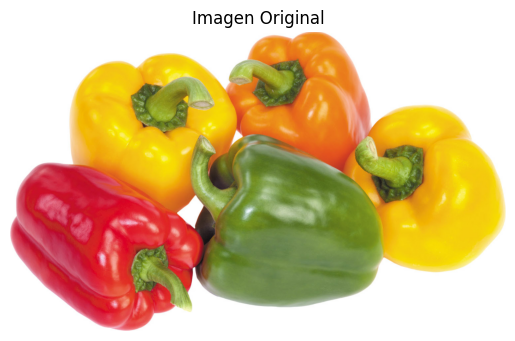

In [ ]:
img = Image.open(filename).convert('RGB')
rgb_matrix = np.array(img)
print(f"\nDimensiones de la imagen: {rgb_matrix.shape}")
print("(Alto, Ancho, Canales de color)")

# Mostrar la imagen
plt.imshow(rgb_matrix)
plt.axis('off')
plt.title("Imagen Original")
plt.show()

Seleccionar 1000 píxeles al azar para generar en conjunto de entrenamiento

In [ ]:
all_pixels = rgb_matrix.reshape(-1, 3)

np.random.seed(42)
indices = np.random.choice(all_pixels.shape[0], 1000, replace=False)

X_train = all_pixels[indices]

print(f"Dataset de entrenamiento preparado: {X_train.shape}")

Dataset de entrenamiento preparado: (1000, 3)


Entrenar modelos

In [ ]:
K = 10 #cross validation layers
clusters_num = [2, 5, 10, 20, 50, 100]
clusters_num_size = len(clusters_num)

kmeans_mse = np.zeros((clusters_num_size,  K))
kmeans_mae = np.zeros((clusters_num_size,  K))

def kmeans_neg_mse_score(estimator, X, y=None):
    labels = estimator.predict(X)
    reconstructed_X = estimator.cluster_centers_[labels]
    return -mean_squared_error(X, reconstructed_X)

def kmeans_neg_mae_score(estimator, X, y=None):
    labels = estimator.predict(X)
    reconstructed_X = estimator.cluster_centers_[labels]
    return -mean_absolute_error(X, reconstructed_X)

scoring = {
    'neg_mse': kmeans_neg_mse_score,
    'neg_mae': kmeans_neg_mae_score,
}

for idx, num in enumerate(clusters_num):
  kmeans = KMeans(n_clusters=num, random_state=42)
  kf = KFold(n_splits=K, shuffle=True, random_state=42)
  # 5. Run Cross-Validation
  results = cross_validate(kmeans, X_train, cv=kf, scoring=scoring)
  kmeans_mse[idx]  = -results['test_neg_mse']
  kmeans_mae[idx]  = -results['test_neg_mae']


Métricos para valores medias aleatorias

In [ ]:
random_means_mse = np.zeros((clusters_num_size, K))
random_means_mae = np.zeros((clusters_num_size, K))
np.random.seed(42)
min_value = np.min(X_train)
max_value = np.max(X_train)
random_means_models = {}
for idx, num in enumerate(clusters_num):
  for k in range(K):
    valoresMedias = np.random.uniform(min_value, max_value, (num, 3))
    diff = X_train[:, None] - valoresMedias
    dist_sq = np.sum(diff**2, axis=2)

    min_dist_sq = np.min(dist_sq, axis=1)
    random_means_mse[idx, k] = np.mean(min_dist_sq)

    dist_abs = np.sum(np.abs(diff), axis=2)
    min_dist_abs = np.min(dist_abs, axis=1)
    random_means_mae[idx, k] = np.mean(min_dist_abs)

  random_means_models[num] = valoresMedias


Boxlots

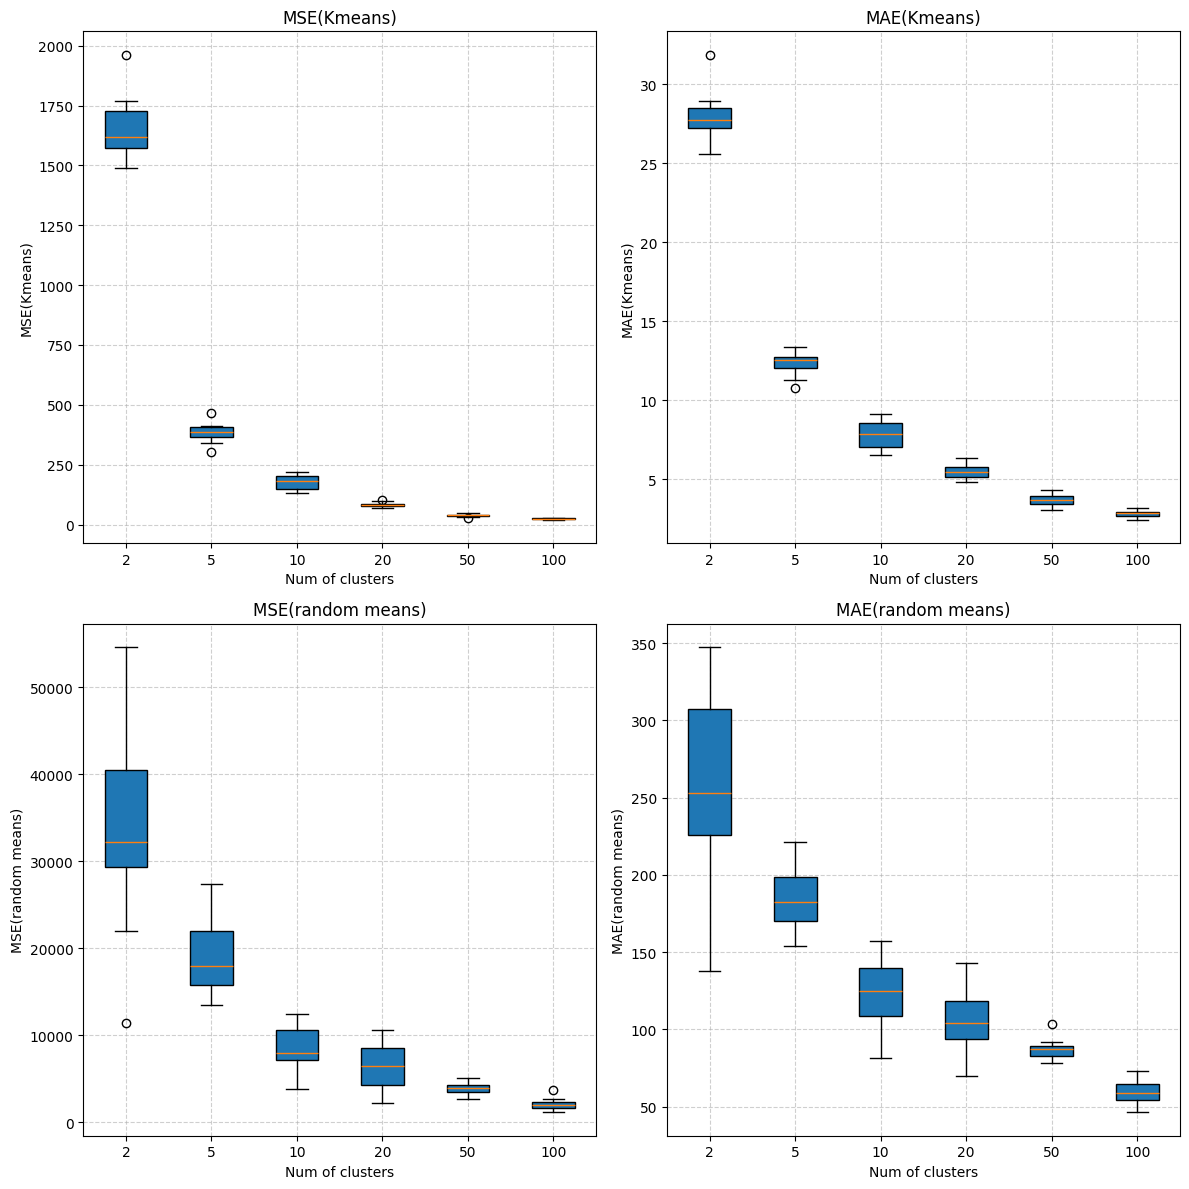

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
metrics_data = [
    (kmeans_mse, 'MSE(Kmeans)'),
    (kmeans_mae, 'MAE(Kmeans)'),
    (random_means_mse, 'MSE(random means)'),
    (random_means_mae, 'MAE(random means)'),
]
for ax, (data, title) in zip(axes.ravel(), metrics_data):
    ax.boxplot([row for row in data], patch_artist=True)
    ax.set_title(title)
    ax.set_xlabel('Num of clusters')
    ax.set_ylabel(title)
    ax.set_xticklabels([num for num in clusters_num])
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Ejercicio 2
Vemos que los métricos mse y mae se mejoran lo más que aumentamos el número de clusters. Además, el rendimiento del algoritmo KMeans es mucho mejor y más estable que el rendimiento que tenemos si seleccionamos los valores medios al azar. Se ve también que lo más que aumentamos el número de clusters lo menos que se mejora el rendimiento(diminishing returns)

# Ejercicio 3 y 4

KMeans

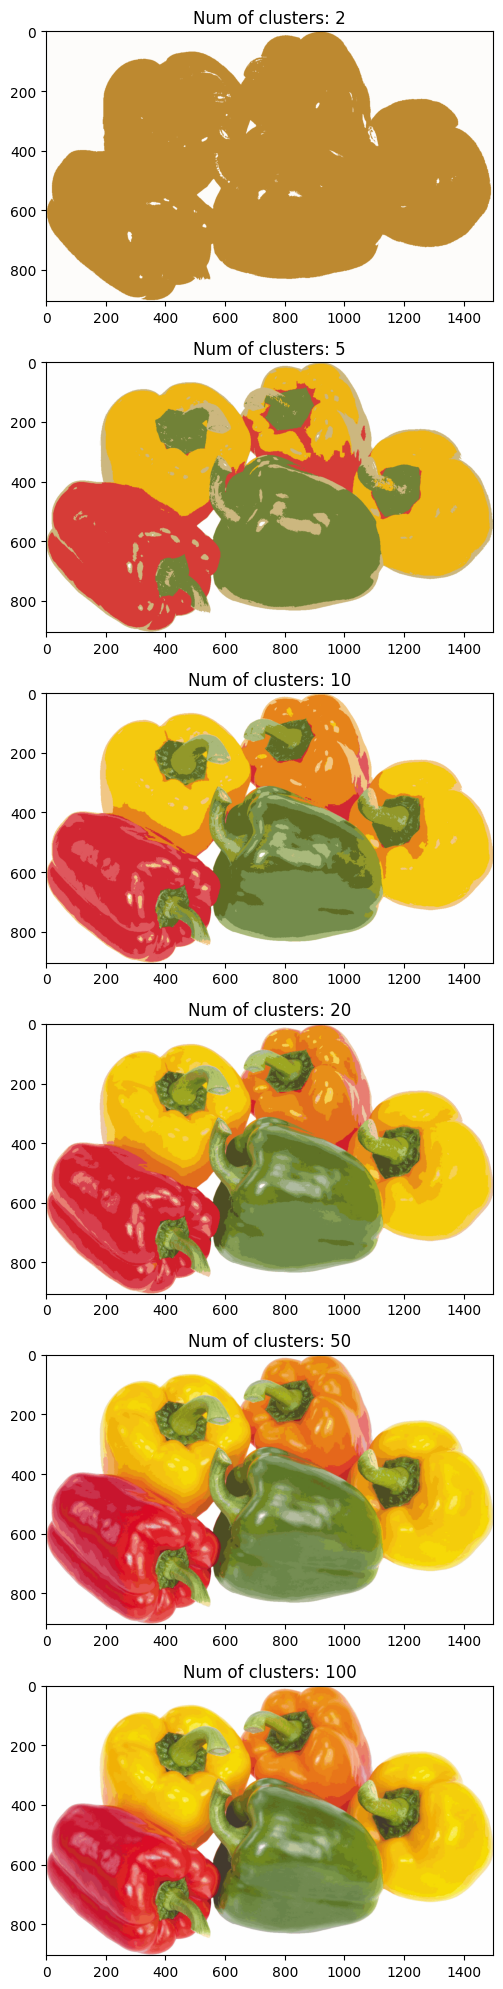

In [ ]:
fig, axes = plt.subplots( clusters_num_size, figsize=(20, 20))
for idx, num in enumerate(clusters_num):
  kmeans = KMeans(n_clusters = num, random_state=42)
  kmeans.fit(X_train)
  x_test = rgb_matrix.reshape(905 * 1500, 3)
  predictions_labels = kmeans.predict(x_test)

  predictions_colors = kmeans.cluster_centers_[predictions_labels]
  predictions_colors_image = predictions_colors.reshape(905, 1500, 3).astype(np.uint8)
  axes[idx].imshow(predictions_colors_image)
  axes[idx].set_title(f'Num of clusters: {num}')

plt.tight_layout()
plt.show()


Se observa que cuanto más aumentamos el número de clusters  más que se acerca la aproximación de kmeans a la imagen original. Concretamente,

numero de clusters: 2 El modelo solo logra distinguir areas de la imagen blancas y areas que no son blancas

numero de clusters: 5 Ya tenemos una aproximación bastante buena mostrando la mayor parte de la información de la imagen

numbero de clusters 10, 20, 50 Empezamos a ver más y más detalles de la imagen

numero de clusters 100 La aproximacion es casi indistinguible de la imagen original.

En general, se ve que el model distingue con más facilidad colores muy diferentes(blanco y colores oscuros, rojo y verde) y necesita más clusters para distinguir entre colores similares(naranja y amarillo) y aún más clusters para distinguir entre matices del mismo color

Random Means

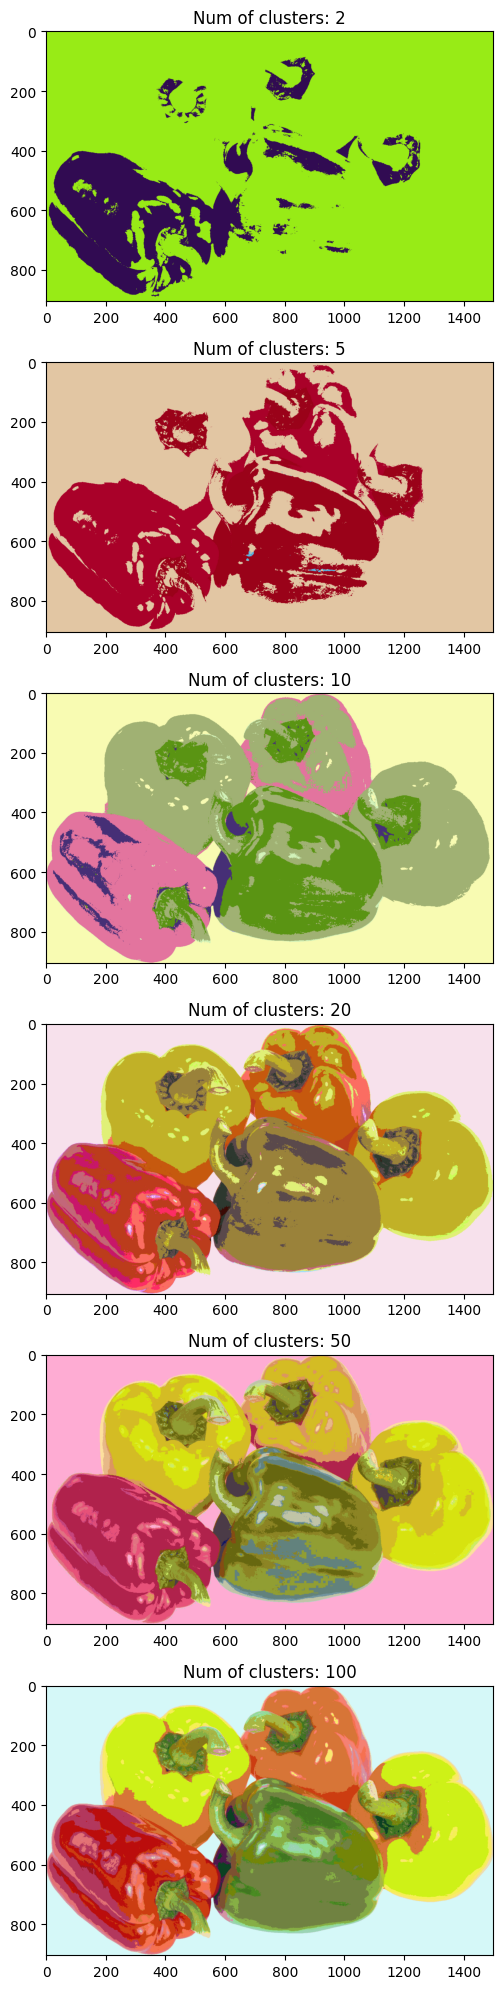

In [ ]:
fig, axes = plt.subplots( clusters_num_size, figsize=(20, 20))
for idx, num in enumerate(clusters_num):
  x_test = rgb_matrix.reshape(905 * 1500, 3)

  clusters = random_means_models[num]
  labels = pairwise_distances_argmin(x_test, clusters)
  predictions_colors = clusters[labels]
  predictions_colors_image = predictions_colors.reshape(905, 1500, 3).astype(np.uint8)
  axes[idx].imshow(predictions_colors_image)
  axes[idx].set_title(f'Num of clusters: {num}')

plt.tight_layout()
plt.show()


Se ve inmediatamente la diferencia entre el modelo kmeans y el usar valores medios al azar. En estos gráficos tenemos distorsión de colores y colores que no existen en nuestra images. Por lo tanto, una aproximación buena y detallada sería imposible